# Deep-Contextualized Embeddings ( ELMO )
> How to implement the ELMO paper in fast.ai [paper](https://arxiv.org/abs/1802.05365)

- toc: true
- badges: true
- comments: true
- sticky_rank: 1
- author: Abhishek Sharma
- image: images/elmo.webp
- categories: [optimization, math, deeplearning, fast.ai]

In this post, I will explore the key ideas presented in the ELMo paper and discuss what it teaches us as a research community. The focus will be on understanding the big concepts and implementing them using fast.ai. To keep it practical, we will work on a toy dataset and prioritize implementation over reproducing the original paper’s results.

## Paper details

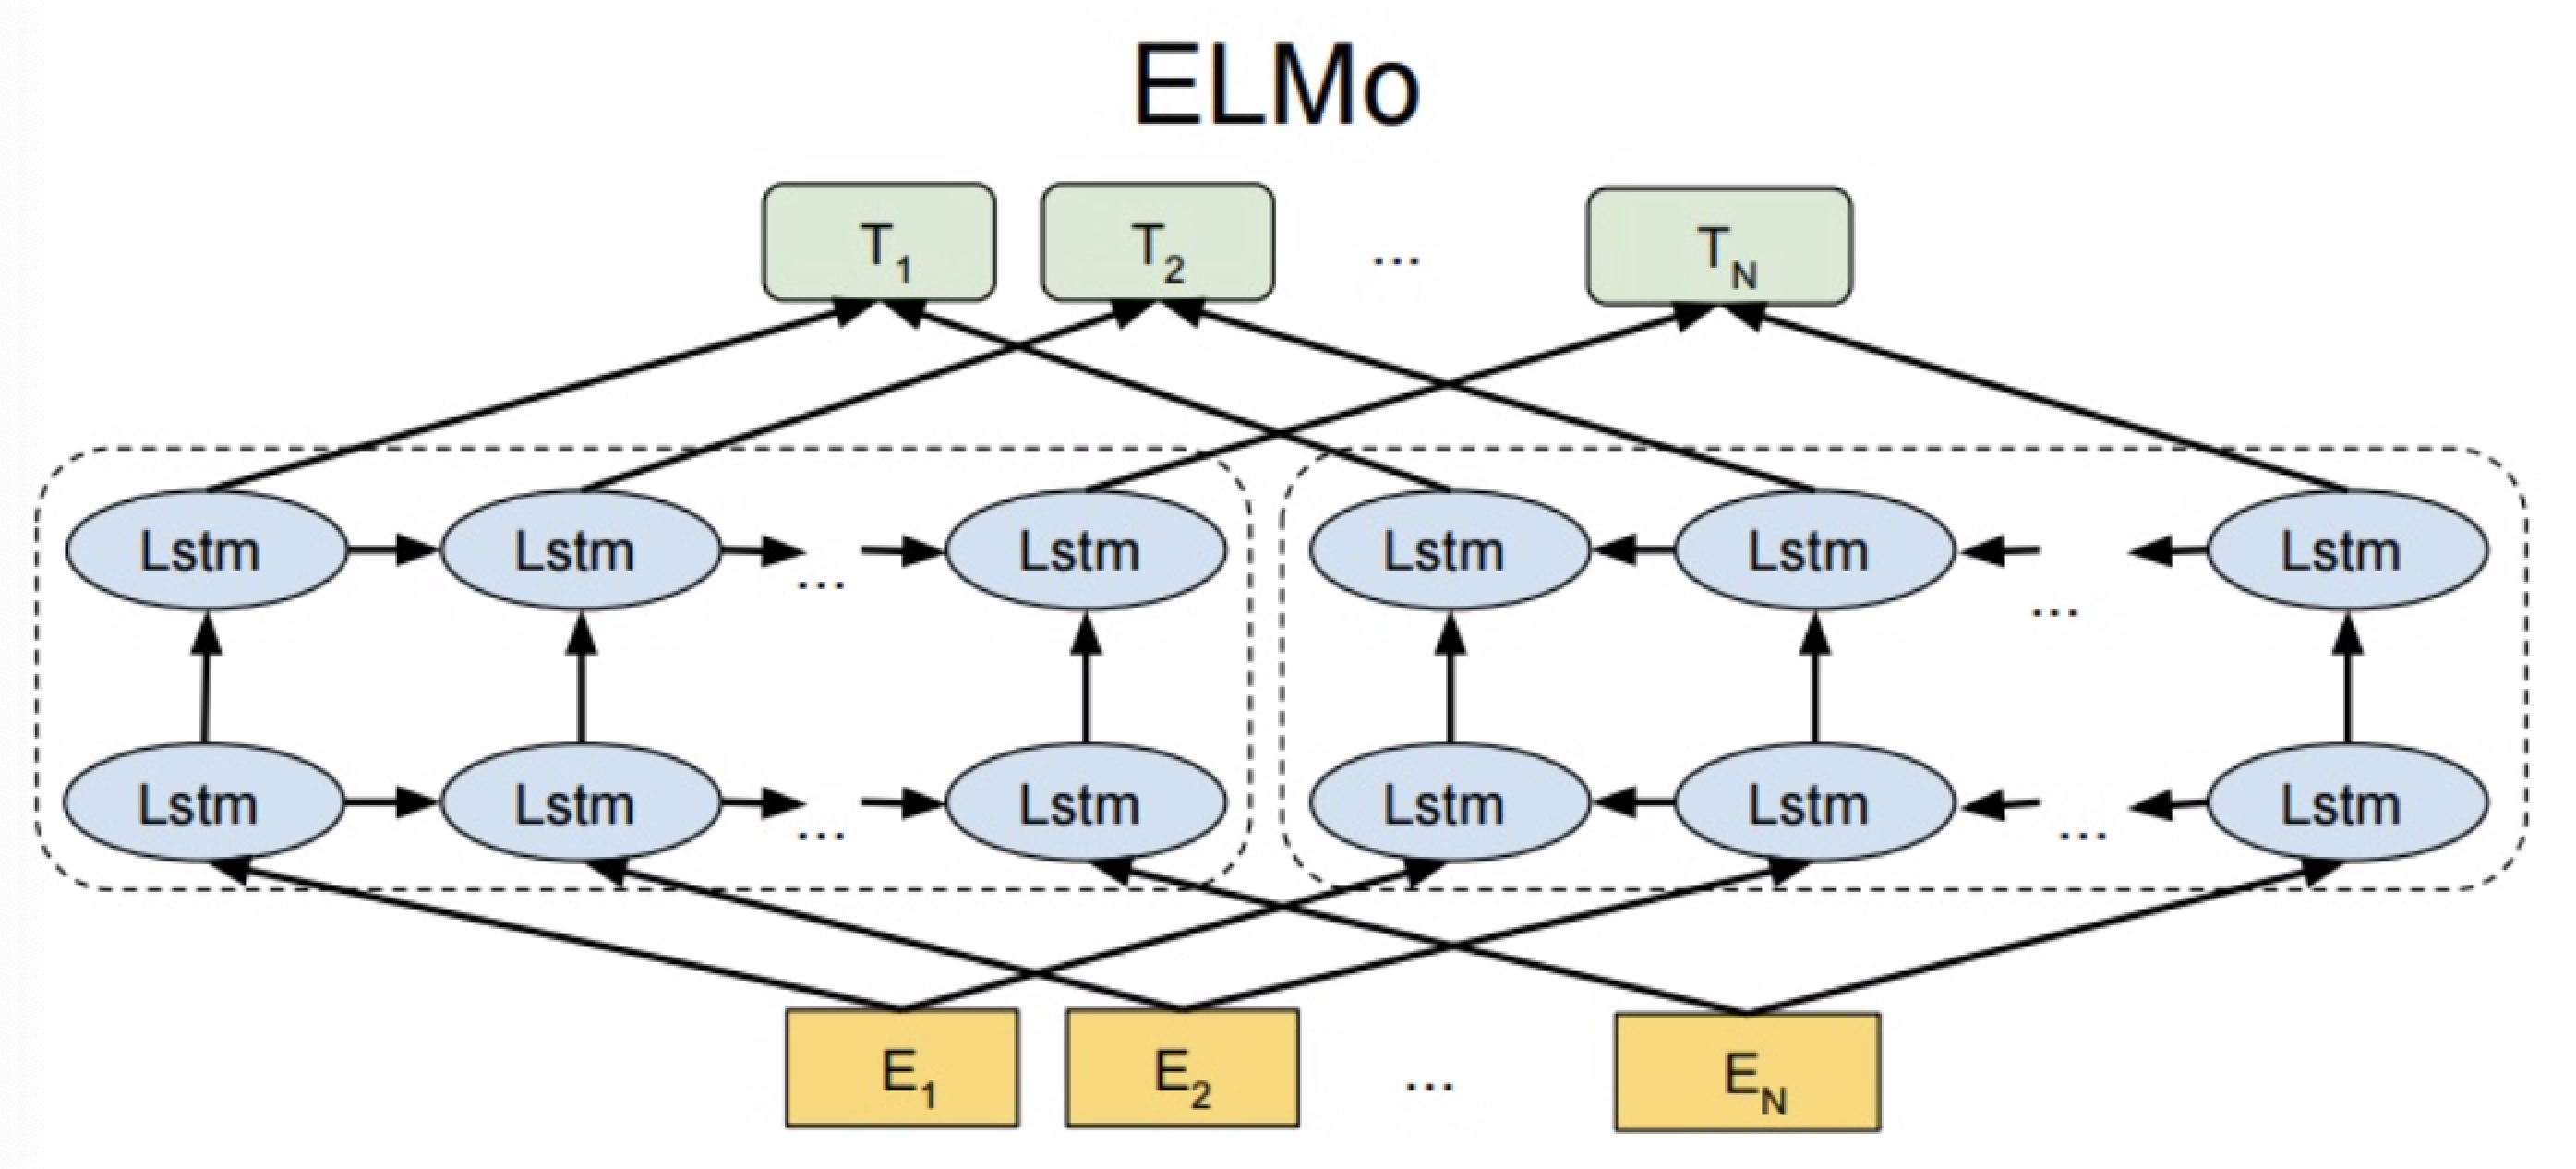

### Contextualized Word Embeddings

#### Limitations of Word2Vec paper

##### Why Settle for One Embedding When Words Have Multiple Meanings?


Consider the word stick in these sentences:

* Let’s stick to the plan.
* He picked up a stick.

The meaning of stick changes based on its context. So, why not embed words in a way that captures this contextual nuance?

ELMo (Embeddings from Language Models) solves this problem by creating contextualized word embeddings. Instead of static embeddings, ELMo uses multiple layers to generate embeddings based on surrounding context.

The architecture consists of the following key components (as illustrated in the figure):

* Embedding Layer
* Two-layer BiLSTM
* Top Layer: Contextualized Word Representation

### Character Embedding Layer

The Character Embedding Layer in ELMo represents words using character-level features. This layer helps capture morphological details such as prefixes and suffixes, which are especially useful for handling out-of-vocabulary words and subword structures.

*Key components:*

* Character Embeddings: Each word is broken into characters, and an embedding is assigned to each character.
* CNN for Feature Extraction: A Convolutional Neural Network (CNN) is applied to extract character-level features from the input word.
* Multiple Convolutional Kernels: The CNN uses multiple kernels (filters), each corresponding to different window sizes. This enables the model to learn features at varying character-level contexts.
* Feature Vector: The output is a fixed-size character-level feature vector that encodes morphological information for the word.

### Bi-LSTM Layer

The Bi-LSTM Layer in ELMo is designed to capture rich semantic information by processing text bidirectionally:

It scans the input left-to-right and right-to-left simultaneously.
The input passes through the following sequence of layers:

* Character-based CNN Encoder: Extracts character-level features.
* Two Bi-LSTM Layers: Captures context-dependent word representations by combining information from both directions.

This bidirectional approach ensures that the embeddings are deeply contextualized, incorporating information from the entire sentence.

### Character CNN Encoder

The Character CNN Encoder processes the input at the character level to generate dense representations for words. Below is the step-by-step breakdown:

* Input Shape:

[batch, max_sentence_len, max_word_len]

* Reshape:
The input is reshaped to:

[batch * max_sentence_len, max_word_len]

* Character Embedding:
Pass the reshaped input through an embedding layer to get:

[batch * max_sentence_len, max_word_len, embedding_dim]

embedding_dim is a predefined hyperparameter, e.g., 16.
The embedding weights are learned during training.
This step maps the one-hot encoded input of size 50 to a dense representation of size 16.

* Transpose:
Transpose the output to prepare it for convolution:

`[batch * max_sentence_len, embedding_dim, max_word_len]`

* Convolutional Layers:
Pass the transposed output through multiple convolutional layers with varying kernel sizes and output channels:

`[batch * max_sentence_len, out_channels, new_h]`

* Max Pooling:
Apply max pooling along the h dimension to obtain:

`[batch * max_sentence_len, out_channels]`

* Concatenation:
Concatenate the outputs of all convolutional layers along the out_channels dimension to form:

`[batch * max_sentence_len, n_filters]`
n_filters represents the total number of output channels summed across all kernels.

* Highway Layers:
Pass the concatenated output through two highway layers, defined as:

`y = g * x + (1 - g) * f(A(x))`
where g = Sigmoid(B(x))

This operation preserves the output shape.

* Linear Projection:
Apply a linear projection to map the output to the desired dimension:

`[batch * max_sentence_len, output_dim]`

* Final Reshape:
Reshape the output back to:

`[batch, max_sentence_len, output_dim]`

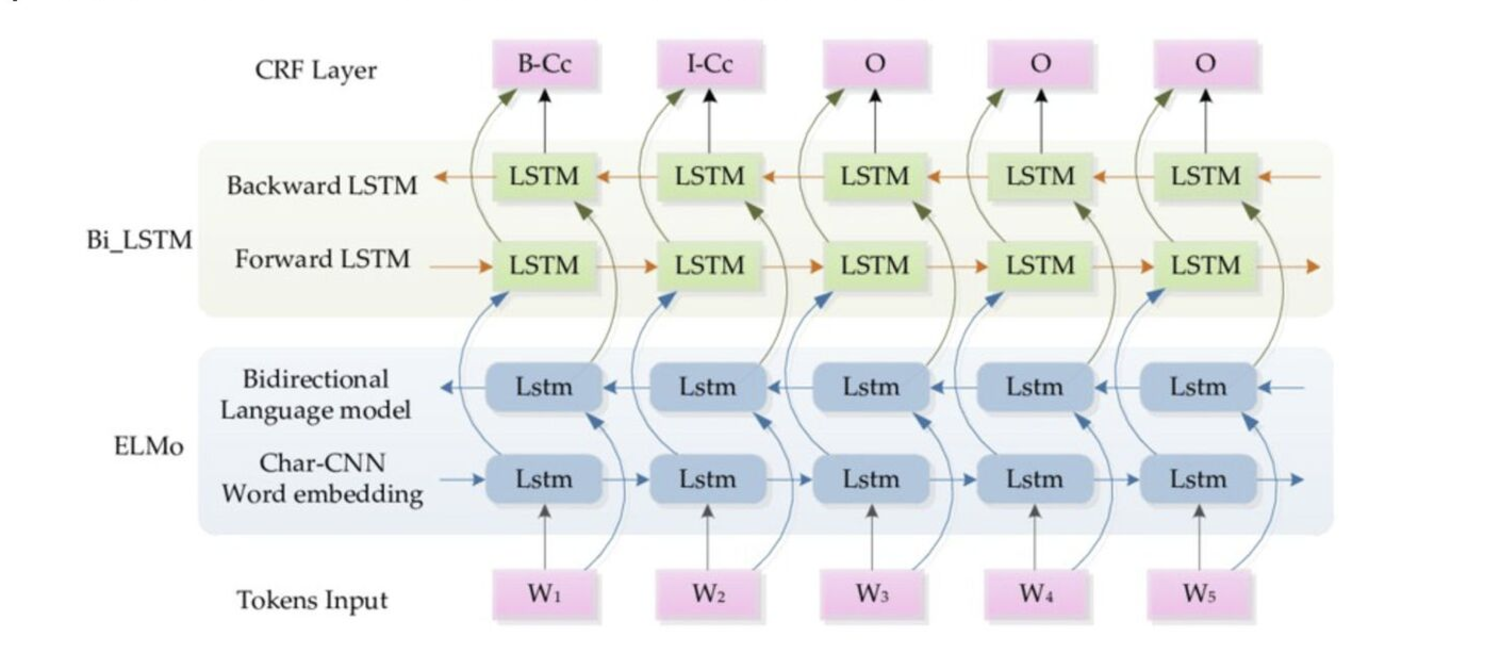

### Bi-LSTM

* Char CNN's output passes through forward layer `[ batch, max_sentence_len, hidden_size ]` and backward layer `[ batch, max_sentence_len, hidden_size ]`
* Concat forward and backward data in the hidden_size dim to get `[b, max_sentence_len, 2 * hidden_size]`

In [ ]:
from fastai.torch_basics import *
from fastai.text.all import *

In [ ]:
from datasets import load_dataset
dsd = load_dataset('karpathy/tiny_shakespeare', trust_remote_code=True)
train, valid, test = dsd['train'][0]['text'], dsd['validation'][0]['text'], dsd['test'][0]['text']

We would use the tiny-shakespeare dataset which contains  40,000 lines of Shakespeare from a variety of Shakespeare's plays.

In [ ]:
@delegates()
class ELMODataLoader(LMDataLoader):
    "A `DataLoader` suitable for Continuous Bag of Words (CBOW)"
    def __init__(self, dataset, context_size=2, bs=64, num_workers=0, **kwargs):
        self.context_size = context_size
        super().__init__(dataset, bs=bs, num_workers=num_workers, **kwargs)

    def create_item(self, idx):
      if idx is None: idx = 0
      if is_listy(self.dataset[idx][0]): tokens, char_tokens = self.dataset[idx][0][0], self.dataset[idx][0][1]
      else: tokens, char_tokens = self.dataset[idx][0], self.dataset[idx][1]
      if len(tokens) < 2 * self.context_size + 1:
          raise IndexError("Sentence too short for the given context size")

      context = torch.hstack((tokens[:self.context_size], tokens[self.context_size+1:]))
      target = tokens[self.context_size]

      return (TensorText(context), char_tokens), TensorCategory(target)

    @delegates(TfmdDL.new)
    def new(self, dataset=None, context_size=None, **kwargs):
        context_size = self.context_size if context_size is None else context_size
        return super().new(dataset=dataset, context_size=context_size, **kwargs)

Extending LMDataLoader for CBOW-style Data

To prepare data in the Continuous Bag of Words (CBOW) style, we modify the LMDataLoader to return (context, target word) pairs. Here, the context is a group of surrounding words used to predict the target word.

Example:
Given the sequence:

`x1, x2, y, x3, x4`

If the context size is 2, the model will use:

Context: x1, x2, x3, and x4
Target: y

In [ ]:
texts = list(filter(lambda x: len(x.split()) > 7, train[:100000].split('\n')))
n_trn = len(texts)


val_txts = list(filter(lambda x: len(x.split()) > 7, valid.split('\n')))
texts.extend(val_txts)

# Create a DataFrame
df = pd.DataFrame({'texts': texts})
splits = L([np.arange(n_trn), np.arange(n_trn, n_trn+len(val_txts))])
df.shape

Only consider those lines which have atleast 7 words in the training and validation dataset.

In [ ]:
class NGramsTokenizer():
    def __init__(self, n=1):
        self.n = n

    def __call__(self, sent):
        words = sent.split()
        ngrams = [[''.join(word[i:i+self.n]) for i in range(len(word)-self.n+1)] for word in words]
        return ngrams

class NumericalizeChars(Numericalize):
  def encodes(self, x): return [[self.o2i[l_] for l_ in o_ ] for o_ in x]

class ElmoTransform(Transform):
  def __init__(self, word_vocab, char_vocab=None):
    self.num_word = Numericalize(min_freq=2)
    self.num_char = NumericalizeChars(min_freq=2)

    self.num_word.setup(word_vocab)
    self.num_char.setup(char_vocab)

  def encodes(self, x):
    tok_word = Tokenizer.from_df('texts')(x)
    tok_char = NGramsTokenizer()(x.lower())

    numer_words = self.num_word(tok_word)
    numer_chars = self.num_char(tok_char)

    return (numer_words,numer_chars)

word_vocab = L(x for x in df.texts.str.split())
char_vocab = L(x for x in df.texts.map(set))

pipe = TfmdLists(df, [attrgetter('texts'), ElmoTransform(word_vocab=word_vocab, char_vocab=char_vocab)])
pipe[0]

Define a custom transform to numericalize both word and character tokens.

In [ ]:
class ElmoPadChunk(Transform):
    def __init__(self,
                 pad_word_idx=1,
                 pad_char_idx=0,
                 pad_first=False,
                 seq_len=72,
                 word_len=32,
                 decode=True,
                 **kwargs):

        store_attr('pad_word_idx, pad_char_idx, pad_first, seq_len,seq_len,word_len')

    def _get_max_word_len(self, batch):
      return max([len(s[0][0]) for s in batch])

    def _get_max_char_len(self, batch):
      return max([len(x) for s in batch for x in s[0][1]])

    def encodes(self, batch):
        X, lbl = zip(*batch)
        xw, xc = zip(*X)

        xw = [(x, ) for x in xw]

        self.max_word_len = self._get_max_word_len(batch)
        self.max_char_len = self._get_max_char_len(batch)

        xc = [
              f[:self.max_word_len] if len(f) > self.max_word_len
              else f + [[self.pad_word_idx]]*(self.max_word_len - len(f))
              for f in xc
             ]

        xc = [[w + [self.pad_char_idx]*(self.max_char_len - len(w)) for w in f]
              for f in xc]

        pw = pad_input_chunk(xw,
                             pad_idx=self.pad_word_idx,
                             pad_first=self.pad_first,
                             seq_len=self.max_word_len
                             )


        pwc = default_collate([x[0] for x in pw])
        pc  = TensorText(xc)
        pc  = pc.transpose(1, 2)

        lbls = default_collate(lbl, )

        return pc, lbls

In [ ]:
vocab_tfm = ElmoTransform(word_vocab=word_vocab, char_vocab=char_vocab)

vw = vocab_tfm.num_word.vocab
vc = vocab_tfm.num_char.vocab

tfms  = [attrgetter('texts'), vocab_tfm]
dsets = Datasets(df, [tfms], splits=splits, dl_type=ELMODataLoader)

bs,cs = 16,1

dl_kwargs = {
    'before_batch': ElmoPadChunk(pad_word_idx=1, pad_char_idx=1),
    'create_batch': fa_convert
}

dls = dsets.dataloaders(bs=bs, context_size=cs, **dl_kwargs)

In [ ]:
class CharacterLayer(Module):
    def __init__(self, input_dim, embedding_dim, output_dim, filters_list, kernel_size_list, highway_num):
        store_attr()
        self.embedding = nn.Embedding(input_dim, embedding_dim)

        self.convs = nn.ModuleList([
            nn.Conv1d(embedding_dim, f, k, padding='same')
            for f, k in zip(filters_list, kernel_size_list)
        ])

        self.dim = sum(filters_list)
        self.highways = nn.ModuleList([nn.Linear(self.dim, self.dim*2) for _ in range(highway_num)])

        self.projection = nn.Linear(self.dim, output_dim)

    def forward(self, x):
        # x: (batch_size, seq_len, token_len)
        bs, seq_len, token_len = x.shape

        # Flatten (batch_size, seq_len) for embedding
        x = x.reshape(bs*seq_len, token_len)
        x = self.embedding(x)               # (bs*seq_len, token_len, embedding_dim)
        x = x.permute(0, 2, 1)              # (bs*seq_len, embedding_dim, token_len)

        # Convolutions + max pooling
        outs = []
        for conv in self.convs:
            c_out = conv(x)                  # (bs*seq_len, f, token_len)
            c_out = torch.max(c_out, dim=2)[0]  # max pool along token_len
            c_out = F.relu(c_out)
            outs.append(c_out)

        x = torch.cat(outs, dim=-1)          # (bs*seq_len, sum(filters_list))

        # Highway layers
        for hw in self.highways:
            hw_out = hw(x)                   # (bs*seq_len, 2*self.dim)
            a = F.relu(hw_out[:, :self.dim])
            g = torch.sigmoid(hw_out[:, self.dim:])
            x = a*g + x*(1-g)

        # Projection
        x = self.projection(x)               # (bs*seq_len, output_dim)
        x = x.reshape(bs, seq_len, -1)       # (bs, seq_len, output_dim)
        return x

In [ ]:
class Elmo(Module):
    def __init__(self, lstm_num):
        store_attr()

        self.embedding = CharacterLayer(
            input_dim=len(vc),
            embedding_dim=16,
            output_dim=50,
            filters_list=[12,24],
            kernel_size_list=[2,3],
            highway_num=2
        )

        self.forward_lstm = nn.ModuleList()
        self.backward_lstm = nn.ModuleList()

        for _ in range(lstm_num):
            self.forward_lstm.append(nn.LSTM(50, 50, batch_first=True))
            self.backward_lstm.append(nn.LSTM(50, 50, batch_first=True))

        # Append one more forward and backward LSTM as in the original code
        self.forward_lstm.append(nn.LSTM(50, 50, batch_first=True))
        self.backward_lstm.append(nn.LSTM(50, 50, batch_first=True))

        self.forward_projection = nn.Linear(50, len(vw))
        self.backward_projection = nn.Linear(50, len(vw))

    def _run_lstm(self, lstm, x, backwards=False):
        # If backwards=True, we simulate go_backwards by flipping the sequence dimension
        if backwards:
            x = torch.flip(x, dims=[1])
        x, _ = lstm(x)
        if backwards:
            x = torch.flip(x, dims=[1])
        return x

    def forward(self, inputs):
        # inputs: (batch, seq_len, token_len)
        x = self.embedding(inputs)   # (batch, seq_len, 50)

        # First forward and backward LSTM pass outside the loop, as in original code
        outputs1 = self._run_lstm(self.forward_lstm[0], x, backwards=False)
        outputs2 = self._run_lstm(self.backward_lstm[0], x, backwards=True)

        # Apply all forward LSTMs (including the first one again)
        for lstm in self.forward_lstm:
            outputs1 = self._run_lstm(lstm, outputs1, backwards=False)

        # Apply all backward LSTMs (including the first one again)
        for lstm in self.backward_lstm:
            outputs2 = self._run_lstm(lstm, outputs2, backwards=True)

        outputs1 = self.forward_projection(outputs1)    # (batch, seq_len, vocab_size)
        outputs2 = self.forward_projection(outputs2)    # Original code uses forward_projection again

        # Concatenate along seq_len dimension (dim=1 since batch_first=True)
        out = torch.cat([outputs1, outputs2], dim=1)
        return out.mean(dim=1)

In [ ]:
m = Elmo(lstm_num=2).cuda()

In [ ]:
learner = Learner(dls, m, loss_func=CrossEntropyLossFlat(), metrics=accuracy)

## References

* https://speakerdeck.com/i_mishramayank/deep-contextualized-word-embeddings
* https://arxiv.org/abs/1802.05365